# Detect and track players, ball and referee in football match using `YOLO v11`, `roboflow` and `supervision` packages.

- Using `roboflow` to create dataset
- Using `YOLO` to train model and detect players and ball
- Using `supervision` to visualize boxes around detected objects and set label for them
---

### Install pytorch compatible with `CUDA`
#### First of all download and install `CUDA toolkit` compatible with your Nvidia graphics card from [this link](https://developer.nvidia.com/cuda-downloads)

#### Then install `pytorch` from [this way](https://pytorch.org/get-started/locally/):

![installing pytorch compatible to CUDA platform](./documentation_resources/pytorch_site.png)

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

---
### Verify Nvidia is access

In [1]:
!nvidia-smi

Fri Nov 29 20:07:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              3W /  107W |     179MiB /   8188MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

-----
### install required packages

In [ ]:
!pip install -q ultralytics roboflow supervision

---
### Download ball, players and referee detection dataset from [this link](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

![installing pytorch compatible to CUDA platform](./documentation_resources/ball_and_players_and_referee_detection_dataset.png)

---
### Download base model of `YOLO` form [this link](https://docs.ultralytics.com/tasks/detect/#models)
![models image](./documentation_resources/models.png)
#### I used `YOLO11s`

---
### Imports

In [2]:
import os
import numpy as np
import torch
from ultralytics import YOLO
from tqdm import tqdm
from sports.common.team import TeamClassifier
import supervision as sv

---
### Predefined Variables

In [3]:
HOME = os.getcwd()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---
### Train model to detect `players`, `ball` and `referee`

In [ ]:
base_model = YOLO(f'{HOME}/datasets/yolo11s.pt')
base_model.train(data=f"{HOME}/football/data.yaml", epochs=50, batch=8, imgsz=1280, plots=True, device=DEVICE)

--------
### Validate trained model

In [ ]:
base_model.val(data=f'{HOME}/football/data.yaml', imgsz=1280, device=DEVICE)

#### Our Model TRained Path

In [4]:
OUR_MODEL_PATH = f'{HOME}/runs/detect/train4/weights/best.pt'
SOURCE_VIDEO_PATH = f"{HOME}\clips\download2.mp4"

---
### Download football match clips

- https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
- https://drive.google.com/uc?id=19PGw55V8aA6GZu5-Aac5_9mCy3fNxmEf
- https://drive.google.com/uc?id=1OG8K6wqUw9t7lp9ms1M48DxRhwTYciK-
- https://drive.google.com/uc?id=1yYPKuXbHsCxqjA9G-S6aeR2Kcnos8RPU
- https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu

---
### Object IDs

In [5]:
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

---
### Detect `players`, `ball` and `referee` just using `YOLO`

In [ ]:
model = YOLO(OUR_MODEL_PATH)
result = model(source=SOURCE_VIDEO_PATH, show=True, conf=0.4, save=True)

---
### Collect Crops Of Players

In [6]:
STRIDE = 30


def extract_crops(source_video_path: str):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=STRIDE)
    yolo_model = YOLO(OUR_MODEL_PATH)

    crops = []
    for frame in tqdm(frame_generator, desc="Extracting crops..."):
        results = yolo_model(frame, conf=0.3, save=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        detections = detections[detections.class_id == PLAYER_ID]
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        crops += [
            sv.crop_image(frame, xyxy)
            for xyxy in detections.xyxy
        ]
    return crops


In [7]:
crops = extract_crops(SOURCE_VIDEO_PATH)

Extracting crops...: 0it [00:00, ?it/s]


0: 736x1280 1 goalkeeper, 21 players, 4 referees, 43.0ms
Speed: 5.9ms preprocess, 43.0ms inference, 85.4ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 1it [00:00,  1.33it/s]


0: 736x1280 21 players, 3 referees, 11.6ms
Speed: 6.0ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 10.0ms
Speed: 5.0ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 4it [00:00,  5.56it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 11.0ms
Speed: 8.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 11.0ms
Speed: 4.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 7it [00:01,  9.25it/s]


0: 736x1280 21 players, 2 referees, 11.0ms
Speed: 8.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 10it [00:01, 12.35it/s]


0: 736x1280 22 players, 1 referee, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 1 referee, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 11.0ms
Speed: 7.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 13it [00:01, 14.82it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 16it [00:01, 16.97it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 11.0ms
Speed: 7.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 19it [00:01, 18.29it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 10.6ms
Speed: 6.0ms preprocess, 10.6ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 6.5ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 22it [00:01, 19.54it/s]


0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 7.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 goalkeepers, 19 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 25it [00:01, 13.46it/s]


In [8]:
len(crops)

509

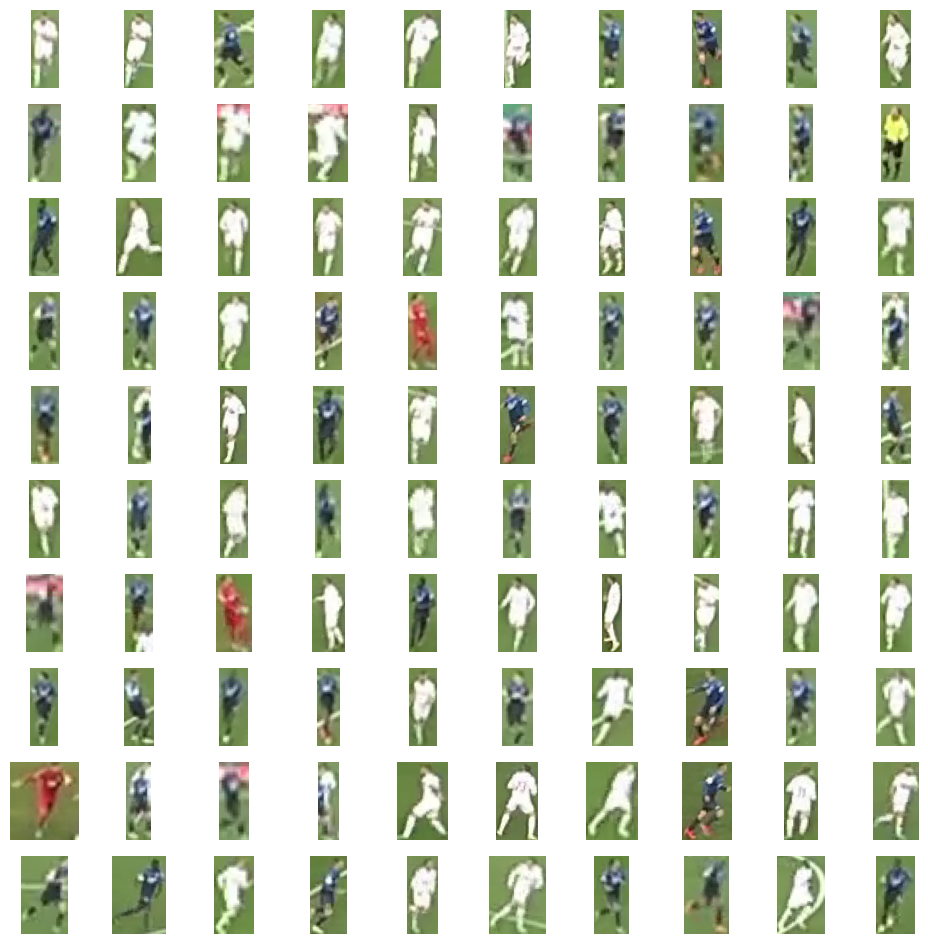

In [9]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

---
### Team Classification

In [ ]:
!pip install -q git+https://github.com/roboflow/sports.git

In [10]:
def resolve_goalkeepers_team_id(players: sv.Detections, goalkeepers: sv.Detections):
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Extracting crops...: 0it [00:00, ?it/s]


0: 736x1280 1 goalkeeper, 21 players, 4 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 1it [00:00,  1.39it/s]


0: 736x1280 21 players, 3 referees, 11.5ms
Speed: 6.0ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 3 referees, 11.0ms
Speed: 6.1ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 21 players, 3 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 4it [00:00,  5.77it/s]


0: 736x1280 1 ball, 21 players, 3 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 2 referees, 11.0ms
Speed: 7.1ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 7it [00:00,  9.48it/s]


0: 736x1280 21 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 2 referees, 11.0ms
Speed: 7.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 21 players, 2 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 10it [00:01, 12.69it/s]


0: 736x1280 22 players, 1 referee, 11.0ms
Speed: 5.5ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 22 players, 1 referee, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 2 referees, 10.5ms
Speed: 7.0ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 13it [00:01, 15.21it/s]


0: 736x1280 1 goalkeeper, 21 players, 3 referees, 11.0ms
Speed: 9.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 22 players, 3 referees, 10.0ms
Speed: 6.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 16it [00:01, 17.24it/s]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 11.0ms
Speed: 7.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 11.0ms
Speed: 5.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 10.0ms
Speed: 7.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 19it [00:01, 18.51it/s]


0: 736x1280 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 5.5ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 7.6ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 10.5ms
Speed: 6.0ms preprocess, 10.5ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 22it [00:01, 19.62it/s]


0: 736x1280 2 balls, 1 goalkeeper, 20 players, 2 referees, 11.0ms
Speed: 7.6ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 13.0ms
Speed: 6.0ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 goalkeepers, 19 players, 2 referees, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Extracting crops...: 25it [00:01, 13.65it/s]
Embedding extraction: 16it [00:03,  4.29it/s]



0: 736x1280 1 goalkeeper, 21 players, 3 referees, 10.0ms
Speed: 5.4ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)


Embedding extraction: 1it [00:00,  7.50it/s]


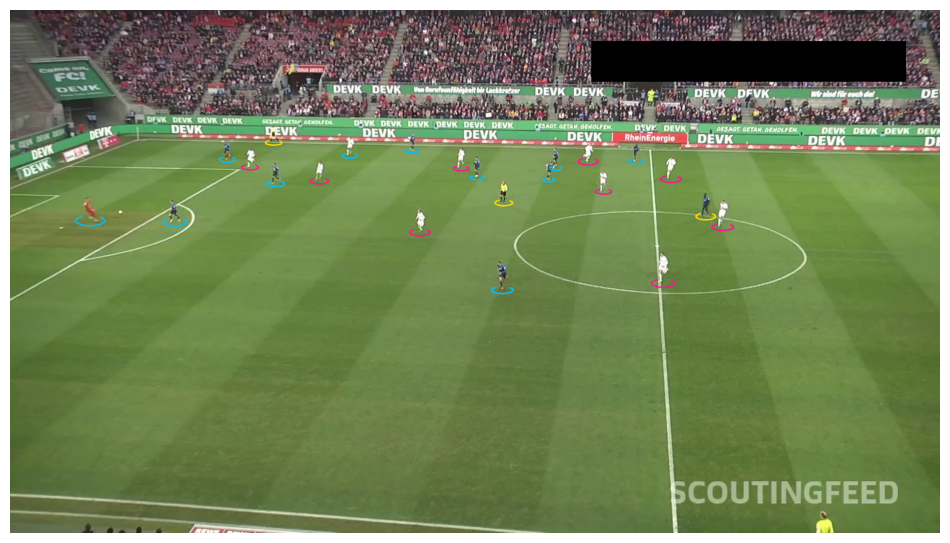

In [22]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

results = yolo_model(frame, conf=0.4, save=False)[0]

detections = sv.Detections.from_ultralytics(results)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

players_detections = all_detections[all_detections.class_id == PLAYER_ID]
goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
referees_detections.class_id -= 1

all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)
sv.plot_image(annotated_frame)


In [ ]:
crops = extract_crops(SOURCE_VIDEO_PATH)
team_classifier = TeamClassifier(device=DEVICE)
team_classifier.fit(crops)

yolo_model = YOLO(OUR_MODEL_PATH)

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20,
    height=17,
)

TARGET_VIDEO_PATH = f"{HOME}/result_clips/result.mp4"

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        results = yolo_model(frame, conf=0.4, save=False, device=DEVICE)[0]

        detections = sv.Detections.from_ultralytics(results)

        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        all_detections = detections[detections.class_id != BALL_ID]
        all_detections = all_detections.with_nmm(threshold=0.5, class_agnostic=True)

        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_detections.class_id = team_classifier.predict(players_crops)

        goalkeepers_detections.class_id = resolve_goalkeepers_team_id(players_detections, goalkeepers_detections)
        referees_detections.class_id -= 1

        all_detections = sv.Detections.merge([players_detections, goalkeepers_detections, referees_detections])

        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

        video_sink.write_frame(annotated_frame)
